In [91]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from pandasql import sqldf
import sqlite3
import math as m
import matplotlib.ticker as mtick
pd.set_option('display.max_columns', None)

In [92]:
db_path = '/Users/tokihossoin/PythonDataAnalysisPrayerAssitApp/Database/paDBL_23.12.23'

# connecting to db
conn = sqlite3.connect(db_path)
# Relevant tables inside db
TABLE_USER = "dim_user"
TABLE_GYRO = "gyroscope"
TABLE_LINACC = "linear_acceleration" #linacc x axis is light sensor data


# Syncing gyro and lin acc as they were collected at the same time
light_sensor_data = f"""
SELECT 
user_id,
prayer_id,
event_time,
RANK() OVER(PARTITION BY user_id,prayer_id ORDER BY event_time) AS ds_order,
x_linacc AS light,
motion,
placement
FROM {TABLE_LINACC} AS light
"""
light_df = pd.read_sql_query(light_sensor_data,conn)
light_df.set_index('user_id',inplace=True)
light_df

,prayer_id,event_time,ds_order,light,motion,placement
user_id,,,,,,
3,1,22-12-2023 20:09:16.535928,1,7.0,bowing,l_moms_room
3,1,22-12-2023 20:09:16.658016,2,7.0,bowing,l_moms_room
3,1,22-12-2023 20:09:16.807829,3,7.0,bowing,l_moms_room
3,1,22-12-2023 20:09:16.948344,4,7.0,bowing,l_moms_room
3,1,22-12-2023 20:09:17.086712,5,7.0,bowing,l_moms_room
...,...,...,...,...,...,...
4,1,22-12-2023 20:22:08.311953,1083,8.0,prostrating,l_moms_room
4,1,22-12-2023 20:22:08.451430,1084,8.0,prostrating,l_moms_room
4,1,22-12-2023 20:22:08.588827,1085,8.0,prostrating,l_moms_room


In [93]:
users_data = f"""
SELECT 
    DISTINCT
    user_id,
    name,
    height
FROM {TABLE_LINACC}
JOIN {TABLE_USER} USING(user_id)
"""
users_df = pd.read_sql_query(users_data,conn)
users_df.set_index('user_id',inplace=True)
users_df

,name,height
user_id,,
3,toki,6.3
4,aklima,5.6


In [94]:
prayer_data = f"""
SELECT 
    DISTINCT
    user_id,
    prayer_id,
    motion,
    name,
    height
FROM {TABLE_LINACC}
JOIN {TABLE_USER} USING(user_id)
ORDER BY 4
"""
prayer_df = pd.read_sql_query(prayer_data,conn)
prayer_df.set_index('user_id',inplace=True)
prayer_df

,prayer_id,motion,name,height
user_id,,,,
4,1,bowing,aklima,5.6
4,1,prostrating,aklima,5.6
3,1,bowing,toki,6.3
3,2,prostrating,toki,6.3
3,3,bowing,toki,6.3
3,4,prostrating,toki,6.3


In [124]:
userid = 3
prayerid = 3

## Name and Height of user data analysed
name = users_df.loc[userid,'name']
height = users_df.loc[userid,'height']
name

'toki'

In [125]:
light_data =f"""
SELECT
    user_id,
    prayer_id,
    ds_order,
    light,
    motion,
    placement
FROM light_df
WHERE TRUE
    -- AND motion = 'prostrating'
    AND prayer_id = {prayerid}
    AND user_id = {userid}
"""

light = sqldf(light_data, globals())
light

,user_id,prayer_id,ds_order,light,motion,placement
0,3,3,1,277.0,bowing,l_p2
1,3,3,2,278.0,bowing,l_p2
2,3,3,3,278.0,bowing,l_p2
3,3,3,4,277.0,bowing,l_p2
4,3,3,5,273.0,bowing,l_p2
...,...,...,...,...,...,...
281,3,3,282,272.0,bowing,l_p2
282,3,3,283,276.0,bowing,l_p2
283,3,3,284,275.0,bowing,l_p2
284,3,3,285,273.0,bowing,l_p2


In [126]:
light_portion =f"""

SELECT
    user_id,
    prayer_id,
    ds_order,
    light,
    motion,
    placement,
    (1 - (light/ (SELECT MAX(light) from light_df where prayer_id = {prayerid} and user_id = {userid}))) *100 AS portion
FROM light_df
WHERE TRUE
    -- AND motion = 'prostrating'
    AND prayer_id = {prayerid}
    AND user_id = {userid}
"""

light_perct = sqldf(light_portion, globals())
light_perct

,user_id,prayer_id,ds_order,light,motion,placement,portion
0,3,3,1,277.0,bowing,l_p2,7.357860
1,3,3,2,278.0,bowing,l_p2,7.023411
2,3,3,3,278.0,bowing,l_p2,7.023411
3,3,3,4,277.0,bowing,l_p2,7.357860
4,3,3,5,273.0,bowing,l_p2,8.695652
...,...,...,...,...,...,...,...
281,3,3,282,272.0,bowing,l_p2,9.030100
282,3,3,283,276.0,bowing,l_p2,7.692308
283,3,3,284,275.0,bowing,l_p2,8.026756
284,3,3,285,273.0,bowing,l_p2,8.695652


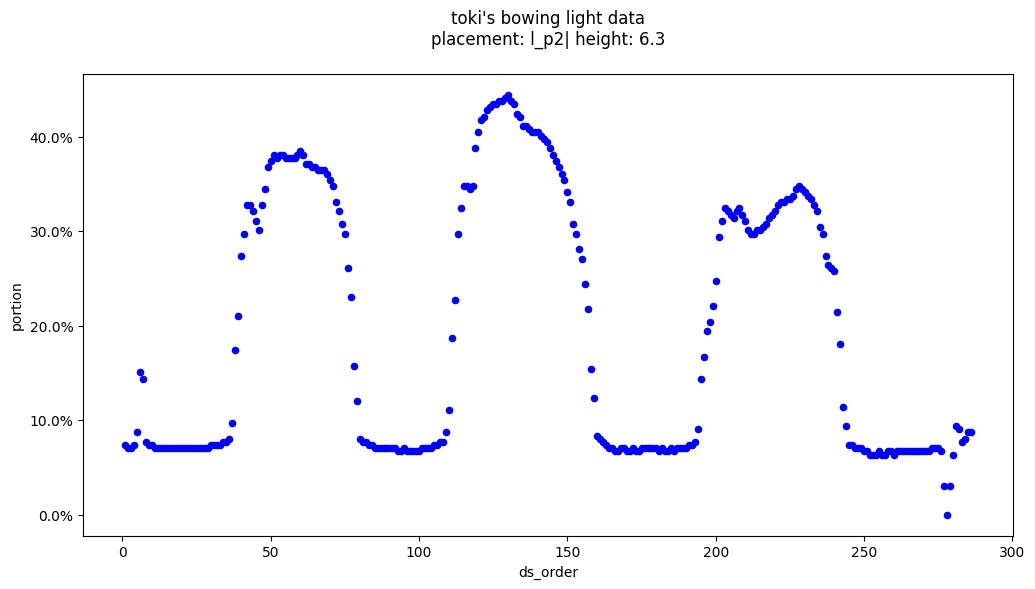

In [127]:
## Graph settings for Gyroscope
fig = plt.figure(figsize=(12, 6))
axes = plt.gca()

## bowing data
plt.title(
f"""{name}'s {light.loc[0,'motion']} light data
placement: {light.loc[0,'placement']}| height: {height}
""")
# light.plot(kind='line', x='ds_order', y='light', color = 'blue',ax=axes);
light_perct.plot(kind='scatter', x='ds_order', y='portion', color = 'blue',ax=axes); axes.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.savefig('/Users/tokihossoin/PythonDataAnalysisPrayerAssitApp/Images/images',dpi=200,bbox_inches ='tight')


In [62]:
"Bowing in moms room, bowing portion from 100% light", (1-(7/8))*100 , "%"

('Bowing in moms room, bowing portion from 100% light', 12.5, '%')

In [63]:
"Bowing in p2 room, bowing portion from 100% light", (1-(170/280))*100 , "%"

('Bowing in p2 room, bowing portion from 100% light', 39.28571428571429, '%')

In [55]:
"Prostrating in moms room, bowing portion from 100% light", (1-(3/8))*100 , "%"

('Prostrating in moms room, bowing portion from 100% light', 62.5, '%')

In [48]:
"Prostrating in p2 room, bowing portion from 100% light", (1-(50/320))*100 , "%"

('Prostrating in p2 room, bowing portion from 100% light', 84.375, '%')

In [65]:
1-(200/280)

0.2857142857142857

In [9]:
conn.close()